In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import linregress

from src import acf_utils, sim


def f(x, tau):
    """exponential decay function for estimating ACF timescale (tau)"""
    return np.exp(-x / (tau if tau > 0 else 1e-6))


def estimate_timescale(X_acf, n_timepoints):
    """estimate the timescale (tau_hat) for each timeseries/region"""
    x = np.arange(n_timepoints)
    curve_fit_kwargs = dict(bounds=(0, np.inf), ftol=1e-6)
    return np.array([curve_fit(f, x, y, **curve_fit_kwargs)[0].squeeze() for y in X_acf])


def plot_grid(X, acf_true, acf_sim, timescales, cutoff=100):
    """plot timeseries + auto-correlation function (ACF)"""

    fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
    fig.tight_layout(pad=3)

    # timeseries
    axs[0].plot(X[:, :cutoff].T, alpha=0.5, label=[f"region-{i}" for i in range(n_regions)])
    axs[0].legend()
    axs[0].set_xlabel("timepoints")
    axs[0].set_ylabel("BOLD signal (au)")

    # acf
    acf_true = acf_true[:, :cutoff] if acf_true.ndim == 2 else acf_true[:cutoff]
    axs[1].plot(acf_true.T, lw=1, c="k", ls="--", label="ACF [true]")
    axs[1].plot(acf_sim[:, :cutoff].T, alpha=0.5, label="ACF [simulated]")
    h, l = axs[1].get_legend_handles_labels()
    axs[1].legend(h[-4:], l[-4:])
    axs[1].set_xlabel("lag (timepoints)")
    axs[1].set_ylabel("autocorrelation")

    # annotate timescales
    colors = [line.get_color() for line in axs[0].lines]
    axs[1].vlines(timescales, 0, 1, colors=colors, alpha=0.5, ls="--")


# set notebook defaults
np.set_printoptions(precision=3, suppress=True)
random_seed = 1
n_regions, n_timepoints = 3, 1200
sampling_rate = 1 / 0.75

# cross-correlation used for all simulations
xcorr = np.array([[1.0, 0.9, 0.3], [0.9, 1.0, 0], [0.3, 0, 1.0]])
xcorr


array([[1. , 0.9, 0.3],
       [0.9, 1. , 0. ],
       [0.3, 0. , 1. ]])

**no auto-correlation**

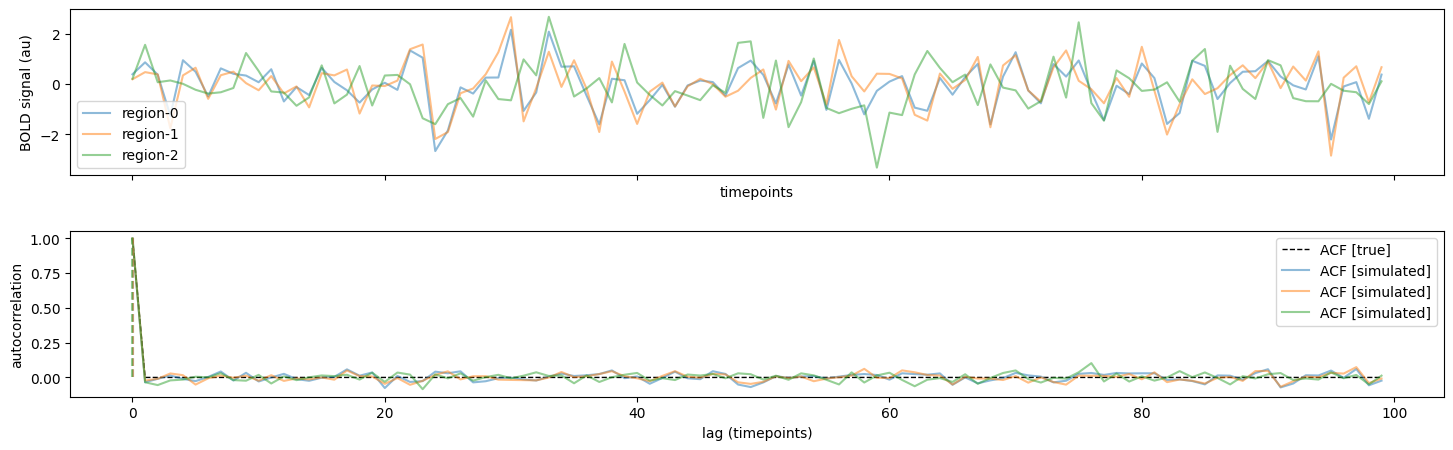

In [2]:
acorr = np.eye(n_timepoints)
acf = acorr[0, :]

X = sim.sim_fmri(xcorr, acorr, n_regions, n_timepoints, random_seed)
X_acf = acf_utils.acf_fft(X, n_timepoints)
X_timescale = estimate_timescale(X_acf, n_timepoints)

# check that cross-correlations are correct
assert np.allclose(xcorr, sim.calc_xcorr(X, n_timepoints, corrected=False), atol=0.1)

plot_grid(X, acf, X_acf, X_timescale)


**realistic fMRI auto-correlation**

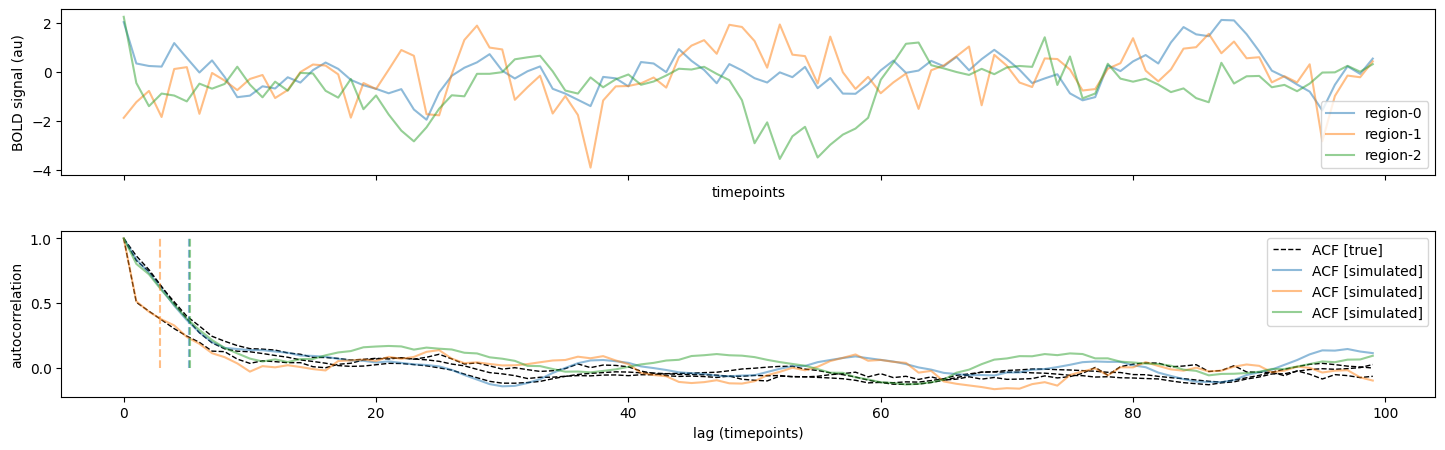

In [3]:
acf = np.load("../tests/data/fmri-acf.npy")
acorr = acf_utils.acf_to_toeplitz(acf, n_timepoints)

X = sim.sim_fmri(xcorr, acorr, n_regions, n_timepoints, random_seed)
X_acf = acf_utils.acf_fft(X, n_timepoints)
X_timescale = estimate_timescale(X_acf, n_timepoints)

# check that cross-correlations are correct
assert np.allclose(xcorr, sim.calc_xcorr(X, n_timepoints, corrected=True), atol=0.1)

plot_grid(X, acf, X_acf, X_timescale)


**exponentially decaying auto-correlation**


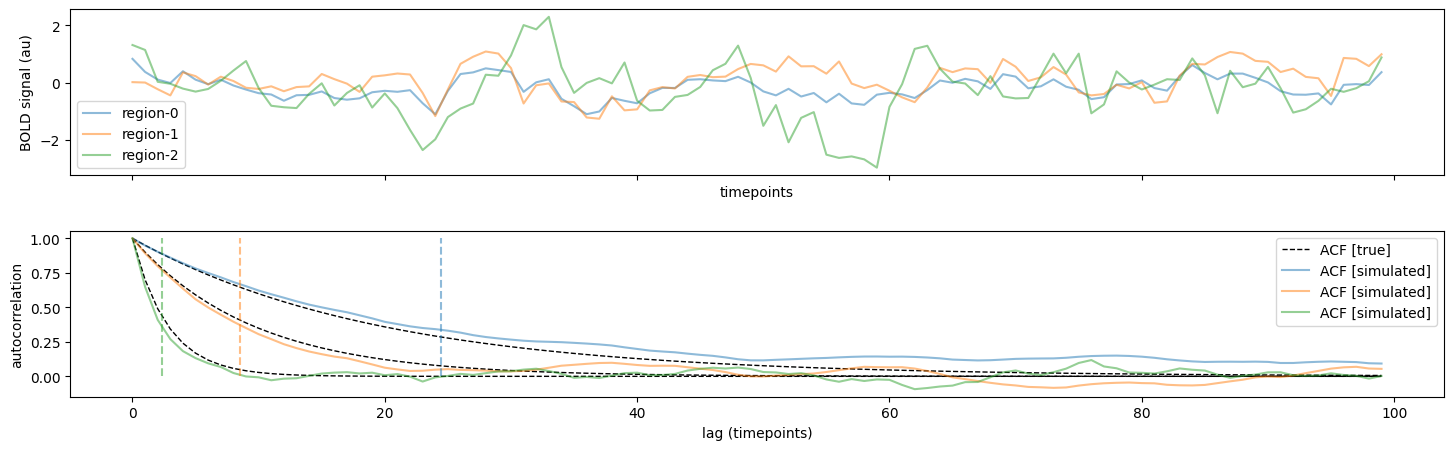

In [4]:
powers = [0.95, 0.9, 0.7]
acf = np.array([np.power(power, np.arange(n_timepoints)) for power in powers])
acorr = acf_utils.acf_to_toeplitz(acf, n_timepoints)

X = sim.sim_fmri(xcorr, acorr, n_regions, n_timepoints, random_seed)
X_acf = acf_utils.acf_fft(X, n_timepoints)
X_timescale = estimate_timescale(X_acf, n_timepoints)

# check that cross-correlations are correct
assert np.allclose(xcorr, sim.calc_xcorr(X, n_timepoints, corrected=True), atol=0.1)

plot_grid(X, acf, X_acf, X_timescale)


**linear vs  nonlinear least  squares for estimating timescales**

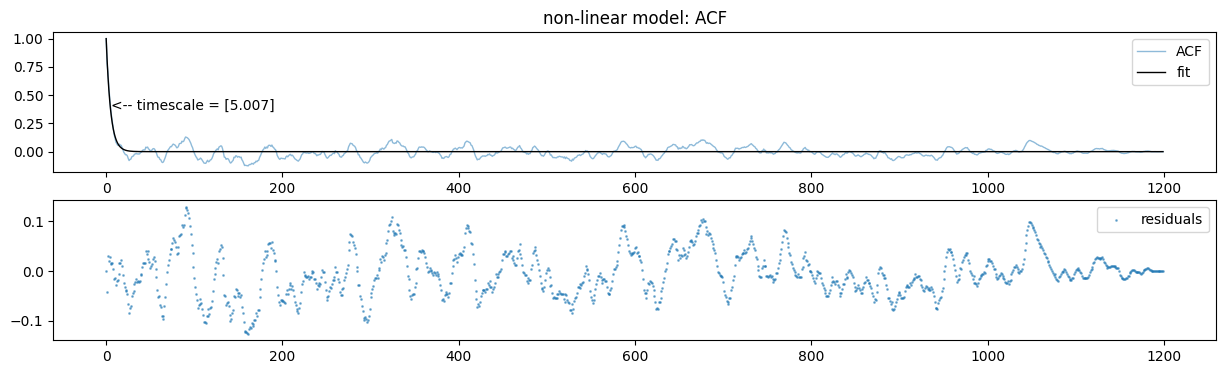

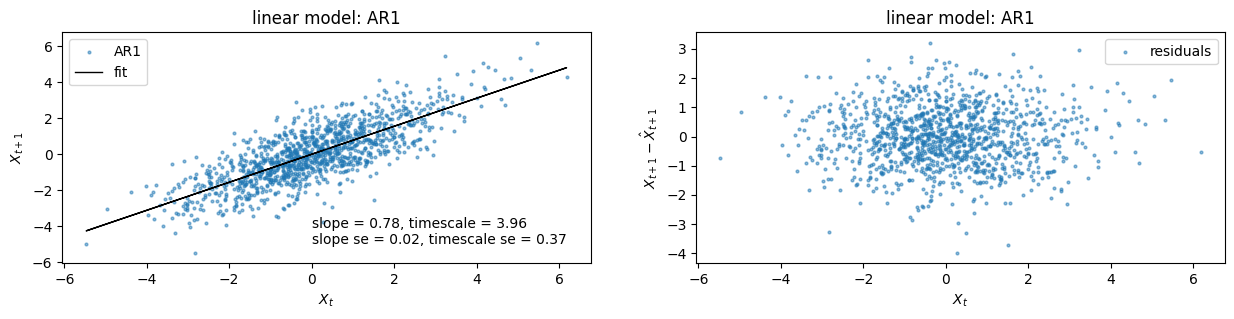

In [5]:
X = sim.sim_ar([0.6, 0.3, -0.1], n_timepoints)  # AR(3)
X_acf = acf_utils.acf_fft(X.reshape(1, -1), n_timepoints).squeeze()
timepoints = np.arange(n_timepoints)

# non-linear model
nlls_timescale, var = curve_fit(f, timepoints, X_acf)
nlls_fit = f(timepoints, nlls_timescale)
nlls_residuals = X_acf - nlls_fit

# linear model
lls = linregress(X[:-1], X[1:])
lls_timescale = -1 / np.log(lls.slope)
lls_fit = lls.intercept + lls.slope * X[:-1]
# delta method for standard error of timescale
lls_se = (1 / (lls.slope * np.log(lls.slope) ** 2)) * lls.stderr
lls_residuals = X[1:] - lls_fit


# plot non-linear model
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].set_title("non-linear model: ACF")

ax[0].plot(timepoints, X_acf, lw=1, alpha=0.5, label="ACF")
ax[0].plot(timepoints, nlls_fit, c="k", lw=1, label="fit")
ax[0].annotate(f"<-- timescale = {nlls_timescale}", (nlls_timescale, 1 / np.e))
ax[0].legend()

ax[1].scatter(timepoints, nlls_residuals, s=1, alpha=0.5, label="residuals")
ax[1].legend()

# plot linear model
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax[0].set_title("linear model: AR1")
ax[1].set_title("linear model: AR1")

ax[0].scatter(X[:-1], X[1:], s=4, alpha=0.5, label="AR1")

ax[0].plot(X[:-1], lls_fit, c="k", lw=1, label="fit")
ax[0].annotate(
    f"slope = {lls.slope:.2f}, timescale = {lls_timescale:.2f}\nslope se = {lls.stderr:.2f}, timescale se = {lls_se:.2f}",
    (0, -5),
)
ax[0].set_xlabel(r"$X_t$")
ax[0].set_ylabel(r"$X_{t+1}$")
ax[0].legend()

ax[1].scatter(X[:-1], lls_residuals, s=4, alpha=0.5, label="residuals")
ax[1].set_xlabel(r"$X_t$")
ax[1].set_ylabel(r"$X_{t+1} - \hat{X}_{t+1}$")
ax[1].legend()


**evaluating bias in the estimated coefficients and standard errors of AR(1) and AR(2) processes**

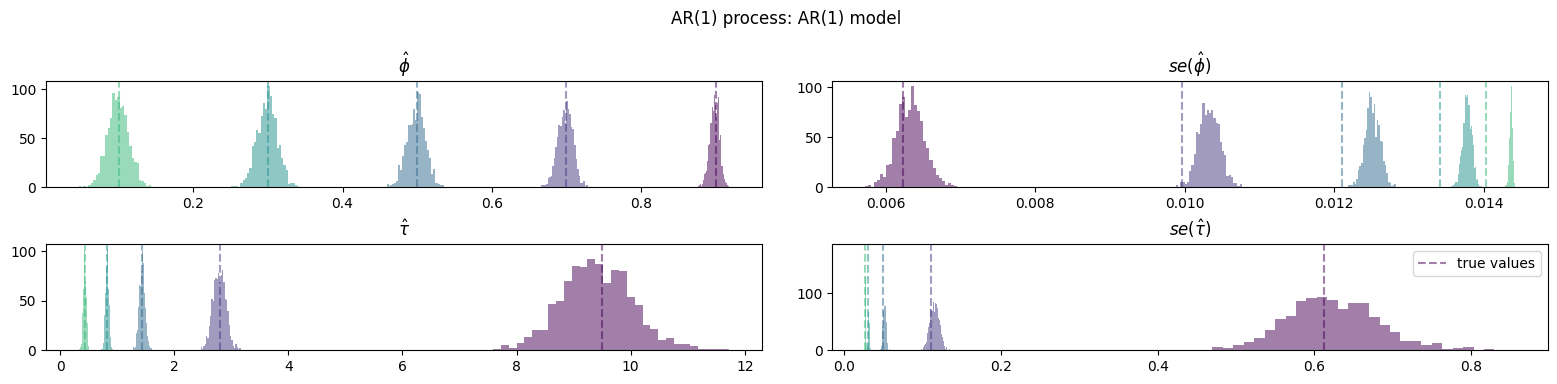

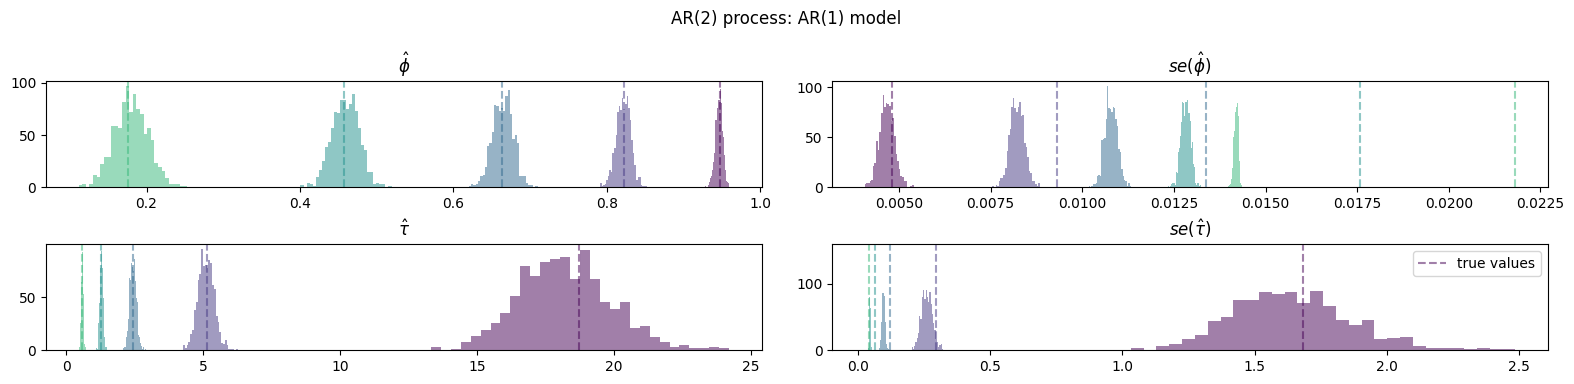

In [6]:
def calc_ar_bias(phis, n_timepoints, n_repeats=1000, random_seed=0):
    """repeate simulations of AR(p) process with fixed coefficients phi_1, phi_2, ..., phi_p"""
    random_state = np.random.default_rng(random_seed)
    random_seeds = random_state.integers(0, 100000, size=n_repeats)

    df = {"phi^": [], "se(phi^)": [], "tau^": [], "se(tau^)": []}

    for random_seed in random_seeds:
        for phi in phis:
            X = sim.sim_ar(phi, n_timepoints, random_seed=random_seed)
            lls = linregress(X[:-1], X[1:])
            df["phi^"].append(lls.slope)
            df["se(phi^)"].append(lls.stderr)
            df["tau^"].append(-1 / np.log(lls.slope))
            df["se(tau^)"].append(1 / (lls.slope * np.log(lls.slope) ** 2) * lls.stderr)

    index = np.tile(np.arange(len(phis)), n_repeats)
    return pd.DataFrame(df, index=index)


def plot_ar_bias(df, ar1_coeffs, fig_title):
    """plot deviations from true values"""
    fig, axs = plt.subplots(2, 2, figsize=(16, 4))
    fig.suptitle(fig_title)
    fig.tight_layout(pad=2)

    # set plotting arguments
    colors = plt.cm.viridis(np.linspace(0, 1, len(ar1_coeffs) + 2))
    hist_kwargs = dict(bins=30, alpha=0.5)
    vline_kwargs = dict(ls="--", alpha=0.5)

    # plot histograms for estimated values, and vlines for true values
    for idx, df_group in df.groupby(level=0):
        # phi
        axs[0, 0].hist(df_group["phi^"], color=colors[idx], **hist_kwargs)
        axs[0, 0].axvline(ar1_coeffs[idx], color=colors[idx], **vline_kwargs)

        # se(phi)
        axs[0, 1].hist(df_group["se(phi^)"], color=colors[idx], **hist_kwargs)
        axs[0, 1].axvline(df_group["phi^"].std(), color=colors[idx], **vline_kwargs)

        # tau
        axs[1, 0].hist(df_group["tau^"], color=colors[idx], **hist_kwargs)
        axs[1, 0].axvline(-1 / np.log(ar1_coeffs[idx]), color=colors[idx], **vline_kwargs)

        # se(tau)
        axs[1, 1].hist(df_group["se(tau^)"], color=colors[idx], **hist_kwargs)
        axs[1, 1].axvline(df_group["tau^"].std(), color=colors[idx], **vline_kwargs)

    axs[0, 0].set_title(r"$\hat{\phi}$")
    axs[0, 1].set_title(r"$se(\hat{\phi})$")
    axs[1, 0].set_title(r"$\hat{\tau}$")
    axs[1, 1].set_title(r"$se(\hat{\tau})$")
    axs[1, 1].legend(["true values"])


n_timepoints = 4800

# AR(1)
ar1_phis = [0.9, 0.7, 0.5, 0.3, 0.1]
ar1_df = calc_ar_bias([[phi] for phi in ar1_phis], n_timepoints)
plot_ar_bias(ar1_df, ar1_phis, "AR(1) process: AR(1) model")

# AR(2), w/in the stationarity triangle
ar2_phis = [[phi, (0.5 - 0.5 * phi)] for phi in ar1_phis]
# AR(1) coeffs calculated empirically using an AR(1) model w/ 100,000 timepoints
ar1_phis = [0.948, 0.823, 0.664, 0.458, 0.176]
ar2_df = calc_ar_bias(ar2_phis, n_timepoints)
plot_ar_bias(ar2_df, ar1_phis, "AR(2) process: AR(1) model")


**Appendix: Delta Method**

The standard errors of the timescale parameter is a function of the autocorrelation coefficient $\phi_1$ of an AR(1) process.

The AR(1) process is defined as:  

$X_t = \phi_1 X_{t-1} + \epsilon_t$

where $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$.

The theoretical autocorrelation function (ACF) of the AR(1) process is:

$\rho_\tau = \phi_1^\tau$

where $\rho_\tau$ is the autocorrelation at lag $\tau$.

...

The *timescale* is defined as the number of lags it takes the ACF to reach $\frac{1}{e}$, which is equivalent to finding the value of $\tau$ that satisfies the equation:

$\phi_1^\tau = \frac{1}{e}$

$\tau \cdot log(\phi_1) = log(\frac{1}{e}) = -1$

$\tau = - \frac{1}{log(\phi_1)}$.

...

To apply the delta method, we express the timescale $\tau$ as a function of the AR(1) coefficient $\phi_1$:

$g(\phi_1) = \frac{-1}{log(\phi_1)}$

$g'(\phi_1) = \frac{1}{\phi_1 log(\phi_1)^2}$.

Then estimate the standard error of the estmated timescale parameter:

$\hat{\sigma}_\tau = g'(\hat{\phi_1}) \cdot \hat{\sigma}_{\phi_1}$

where $\hat{\phi_1}$ is the estimate of the AR(1) coefficient and $\hat{\sigma}_{\phi_1}$ is its estimated standard error.

**stationarity of AR(2) process**

[StackExchange](https://stats.stackexchange.com/questions/118019/a-proof-for-the-stationarity-of-an-ar2)

An AR(2) process is stable if the following three conditions are met:
1. $\phi_2 < 1 + \phi_1$
2. $\phi_2 < 1 - \phi_1$
3. $\phi_2 > -1$